In [4]:
import networkx as nx
import numpy as np 
from matplotlib import pyplot as plt
import collections
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from scipy.sparse import dok_matrix
from scipy.sparse import csgraph
import time
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
from scipy.sparse.csgraph import minimum_spanning_tree
import scipy.sparse as sps
import json
import pickle
import os
import seaborn as sns
from zahn import Zahn
from template import Template_5

In [2]:
algos = os.listdir("fitted")

In [3]:
len(algos)

73

In [4]:
tuples = []

In [5]:
def get_averages(zahn):
    comp_fifth_avg = []
    comp_four = []
    for component in zahn.clusters:
        comp_fifth_avg.append(np.mean([i[-1] for i in component]))
        comp = []
        for vec in component:
            comp.append(vec[:-1])
        comp_four.append(np.array(comp))
    centers = np.array([np.mean(x,axis=0) for x in comp_four])
    zahn.comp_fifth_avg = comp_fifth_avg
    zahn.comp_four = comp_four
    zahn.centers = centers
    zahn.centers_ktree = cKDTree(data=centers)

In [6]:
for a in algos:
    try:
        with open('fitted/' + a, 'rb') as fp:
            zahn = pickle.load(fp)
        print(zahn.template.n1)
        get_averages(zahn)
        t = (zahn.template, zahn.comp_fifth_avg, zahn.centers_ktree)
        tuples.append(t)
    except:
        print('error')

28
9
24
23
3
5
error
26
5
21
1
15
13
19
5
12
17
1
4
10
11
6
5
1
12
2
4
1
4
22
2
29
25
4
20
4
2
3
27
5
13
15
14
18
1
2
11
2
5
1
16
14
5
8
7
4
5
error
12
3
9
4
2
3
7
1
2
4
2
12
6
2
13


In [1]:
from nolitsa import lyapunov

In [59]:
def get_zvec_for_template(series,i,t):
    s = t.n1 + t.n2 + t.n3 + t.n4
    i4 = i - s
    i3 = i - t.n2 - t.n3 - t.n4
    i2 = i - t.n3 - t.n4
    i1 = i - t.n4
    vec = np.array([series[i4],series[i3],series[i2],series[i1]])
    return vec

In [60]:
def get_zvecs_for_algos(series,i,tuples):
    return [get_zvec_for_template(series,i,t[0]) for t in tuples]

In [61]:
get_zvecs_for_algos(series_26,750000,tuples)

[array([-10.01602586,   1.19417701,  -2.46781822, -10.0492415 ]),
 array([  0.82455829, -10.0492415 ,  -4.49137581, -12.02978782]),
 array([-2.62352337, -4.98777855, -2.14996289, -3.87504238]),
 array([-7.10678633, -5.98846659, -8.7815689 , -4.49137581]),
 array([ -7.56607392,  -4.75265475, -11.91765046,  -3.16957165]),
 array([-12.02978782,  -4.75265475, -12.5736412 ,  -3.61725561]),
 array([ -5.10410179,  -1.37733639, -12.45255715,  -9.77570881]),
 array([-12.61667282,  -7.05298206,  -4.67349095,  -4.06915221]),
 array([  1.19417701,  -3.21023241,  -1.09766453, -11.20003627]),
 array([-6.88245219, -3.61725561, -3.16957165, -8.12235906]),
 array([-13.81420848, -14.74776619,  -3.61389785,  -7.7073243 ]),
 array([-8.7815689 , 13.93743561, -4.49137581, -8.12971588]),
 array([-5.91585365, -2.44551278,  0.31305237, -8.57377724]),
 array([-12.02978782,  -4.75265475, -11.91765046,  -3.61725561]),
 array([-2.14996289,  2.25483581, -3.87504238, -7.56607392]),
 array([-10.47935227,  -6.16271605

In [5]:
with open('data/series.json') as fp:
    series_26 = json.load(fp)

In [10]:
def reconstruct_2(ts, m, J=None):
    """
    Function which reconstructs z-vectors with overlapping
    :param ts: The origin time series.
    :param m: The embedding dimensionality
    :param J: J is the delay parameter
    :return:
    """
    l = []
    if np.ndim(ts) == 1:
        # Reshape this array
        ts = ts.reshape(-1, 1)
        l.append(ts[:-(m+1)])
    for i in range(1, m+1):
        ts_sliced = ts[i:-(m-i+1)]
        l.append(ts_sliced)
    ts_reconstructed = np.concatenate(l, axis=1)
    return ts_reconstructed

In [ ]:
l28

In [62]:
def predict_zvec(t,zvec):
    dist,ind = t[2].query(zvec)
    pred = t[1][ind]
    return pred, dist

In [63]:
def predict_point_avg(series,i):
    preds = []
    dists = []
    zvecs_list = get_zvecs_for_algos(series,i,tuples)
    for i in range(len(zvecs_list)):
        pred, dist = predict_zvec(tuples[i],zvecs_list[i])
        preds.append(pred)
        dists.append(dist)
    return np.mean(preds), np.mean(dists)

In [64]:
predict_point_avg(series_26,770000)

(-10.691733089120318, 0.641843831583973)

In [65]:
series_26[750000]

-12.832920091505308

In [66]:
preds_len = 100

In [67]:
test = series_26[749993:]
# starting point 750k
start_ind = 107

In [68]:
def get_preds(series,start,n=10):
    preds = []
    dists = []
    errors = []
    sq_errors = []
    step = 0
    series_dummy = series[:start]
    for i in range(start,start+preds_len):
        if step >= n:
            preds.append(series[i])
            series_dummy.append(series[i])
            step += 1
            if step == n + 7:
                step = 0
        else:
            pred, dist = predict_point_avg(series_dummy,i)
            dists.append(dist)
            preds.append(pred)
            errors.append(abs(series[i]-pred) / max(series))
            mse = (series[i] / max(series) - pred/ max(series))**2
            sq_errors.append(mse)
            series_dummy.append(pred)
            step += 1
    return preds, dists, np.mean(errors), np.mean(sq_errors), np.mean(sq_errors)**(1/2)

In [69]:
preds, dists, mae, mse, rmse = get_preds(test,start_ind)

In [70]:
mae

0.3045559469295155

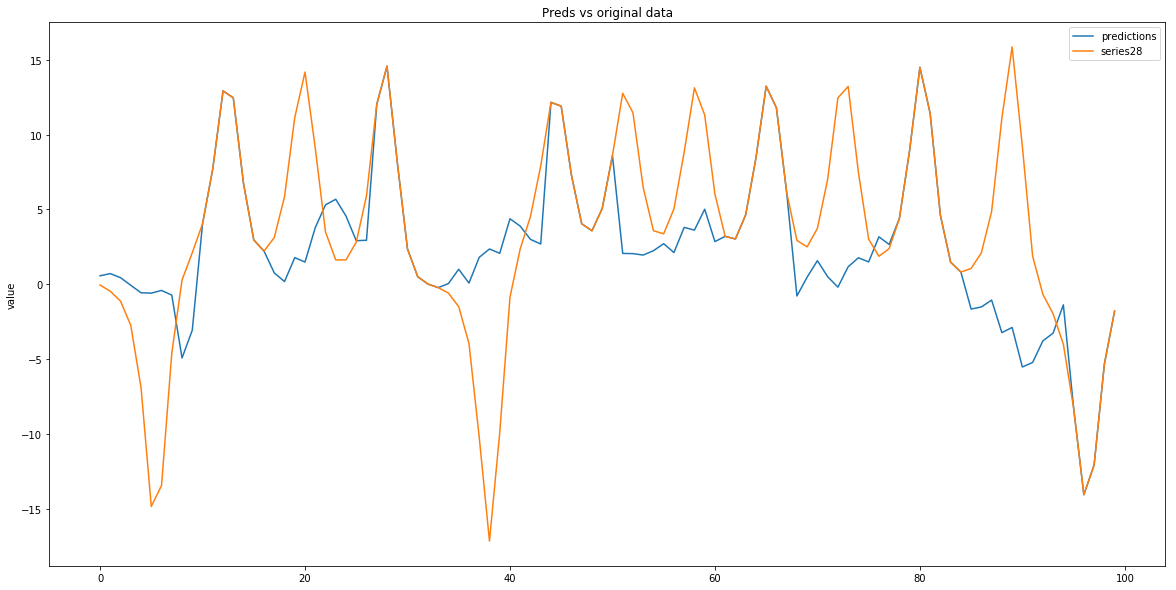

In [71]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(preds_len)], preds[:preds_len], label='predictions')
plt.plot([i for i in range(preds_len)], test[start_ind:start_ind+preds_len], label='series28')
plt.title('Preds vs original data')
plt.ylabel('value')
plt.legend()
plt.show()

In [72]:
preds = []
dists = []

In [73]:
for i in range(760000,760020):
    p,d = predict_point_avg(series_26,i)
    preds.append(p)
    dists.append(d)

In [74]:
preds

[2.3117600858109917,
 1.4095190371162742,
 1.7408864364098333,
 2.905258356997821,
 5.600524557468859,
 10.56893993484669,
 9.584431351404406,
 4.382716592015049,
 1.602239865835269,
 0.956678202965922,
 1.0537283165659932,
 1.5860291129078228,
 3.4767530002920495,
 7.5848416708021,
 10.629303332932059,
 8.782603793119062,
 3.2835753963878336,
 -0.16491766142996186,
 -1.7931143877308944,
 -2.625775571038293]

In [75]:
dists

[0.7891016850993519,
 0.8779863363059038,
 0.9129533418695281,
 0.8564670029500078,
 0.846082032150642,
 0.7280162896945738,
 0.7060908201126141,
 0.807918884649333,
 0.7966982649104292,
 0.7486620436263669,
 0.7850856993600989,
 0.7295925890171482,
 0.7630706605011659,
 0.8655056676138747,
 0.817090383349608,
 0.7182606712218512,
 0.7924659696592532,
 0.8113791473400485,
 0.7751138899032382,
 0.7227007301607205]